# Predict air quality with Prophet


we will use Prophet to help us predict air quality!

In [1]:
# import the necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

# Import Dataset

In [2]:
data = pd.read_csv("AirQualityUCI.csv",sep=';')
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [3]:
data.shape

(9471, 17)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


In [5]:
data.isna().sum()

Date              114
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64

In [6]:
data.dropna(axis = 1,how="all",inplace=True) # drop na value row wise
data.dropna(axis = 0,how= "all", inplace = True) # drop columns na

In [7]:
data.shape

(9357, 15)

In [8]:
data.isna().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [9]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


 the dataset contains information about the concentrations of different gases. They were recorded at every hour for each day. 

If you explore the dataset a bit more, you will notice that there are many instances of the value -200. Of course, it does not make sense to have a negative concentration, so we will need to clean the data before modelling.

Therefore, we need to clean the data.

# Data cleaning and feature engineering

we start off by parsing our date column to turn into “dates”.

In [10]:
data["Date"] = pd.to_datetime(data["Date"]) # changes the date format

turning all the measurements into floats.

In [11]:
for col in data.iloc[:,2:].columns:
    if data[col].dtypes == object:
        data[col] = data[col].str.replace(",",".").astype('float')

we aggregate the data by day, by taking the average of each measurement

In [12]:
def positive_average(num):
    return num[num > -200].mean()

daily_data = data.drop("Time",axis=1).groupby("Date").apply(positive_average)

In [13]:
daily_data.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,,,,,
2004-01-04,2.550000,1244.380952,310.125,11.971429,1010.428571,161.304348,880.666667,96.739130,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-05,2.056522,1097.500000,275.000,8.662500,913.708333,104.739130,918.083333,84.956522,1640.416667,904.625000,20.150000,52.183333,1.167313
2004-01-06,2.100000,1135.583333,NaN,12.375000,1021.875000,152.043478,896.791667,75.869565,1881.500000,1066.958333,20.325000,66.154167,1.533350
2004-01-07,2.162500,1130.583333,NaN,12.225000,1038.541667,139.695652,740.916667,113.434783,1854.250000,1059.625000,30.450000,39.691667,1.624108
2004-01-08,0.983333,974.166667,NaN,5.808333,792.583333,51.739130,880.083333,58.521739,1559.000000,670.583333,30.654167,42.120833,1.673521


In [14]:
daily_data.isna().sum()

CO(GT)            36
PT08.S1(CO)        8
NMHC(GT)         347
C6H6(GT)           8
PT08.S2(NMHC)      8
NOx(GT)           34
PT08.S3(NOx)       8
NO2(GT)           34
PT08.S4(NO2)       8
PT08.S5(O3)        8
T                  8
RH                 8
AH                 8
dtype: int64

In [15]:
# drop the columns with more than 8 NaN
daily_data.isna().sum()>8

CO(GT)            True
PT08.S1(CO)      False
NMHC(GT)          True
C6H6(GT)         False
PT08.S2(NMHC)    False
NOx(GT)           True
PT08.S3(NOx)     False
NO2(GT)           True
PT08.S4(NO2)     False
PT08.S5(O3)      False
T                False
RH               False
AH               False
dtype: bool

In [16]:
daily_data = daily_data.iloc[:,(daily_data.isna().sum()<=8).values]
daily_data.head()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,
2004-01-04,1244.380952,11.971429,1010.428571,880.666667,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-05,1097.500000,8.662500,913.708333,918.083333,1640.416667,904.625000,20.150000,52.183333,1.167313
2004-01-06,1135.583333,12.375000,1021.875000,896.791667,1881.500000,1066.958333,20.325000,66.154167,1.533350
2004-01-07,1130.583333,12.225000,1038.541667,740.916667,1854.250000,1059.625000,30.450000,39.691667,1.624108
2004-01-08,974.166667,5.808333,792.583333,880.083333,1559.000000,670.583333,30.654167,42.120833,1.673521


In [17]:
daily_data.shape

(391, 9)

In [18]:
# Remove rows containing NaN values
daily_data = daily_data.dropna()

In [19]:
daily_data.shape

(383, 9)

we aggregate the data by week, because it will give a smoother trend to analyze

In [20]:
# Aggregate data by weak
weekly_data = daily_data.resample("W").mean()

In [21]:
weekly_data.head()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,
2004-01-04,1244.380952,11.971429,1010.428571,880.666667,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-11,1136.801760,11.674457,1009.344462,760.484990,1727.833075,1083.683747,24.564726,53.224017,1.526858
2004-01-18,1173.375000,13.429167,1050.458333,1490.333333,1448.541667,1196.333333,10.891667,77.000000,1.002796
2004-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
weekly_data = weekly_data.dropna()
weekly_data.shape

(73, 9)

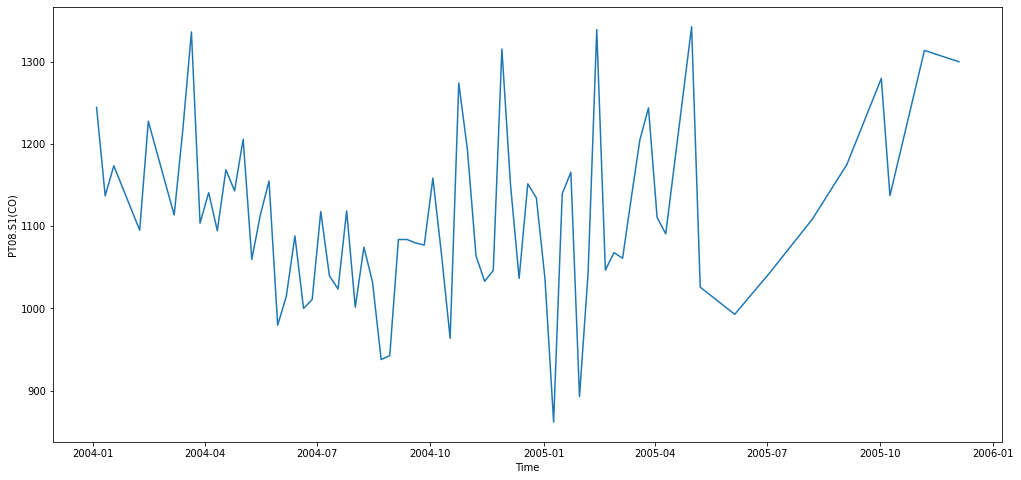

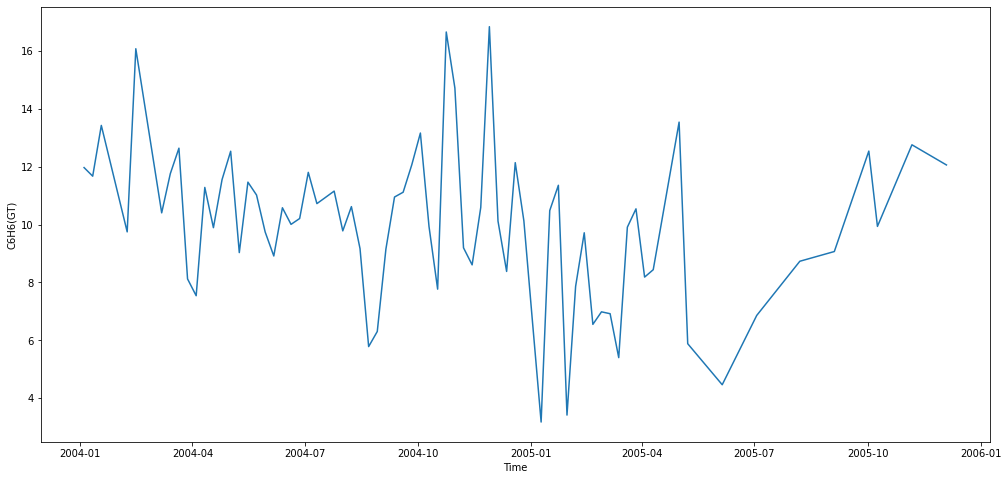

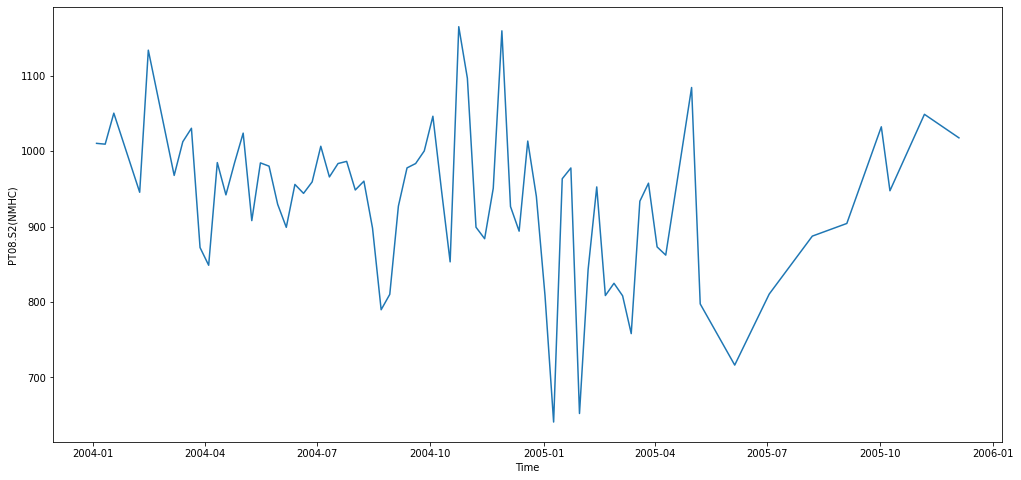

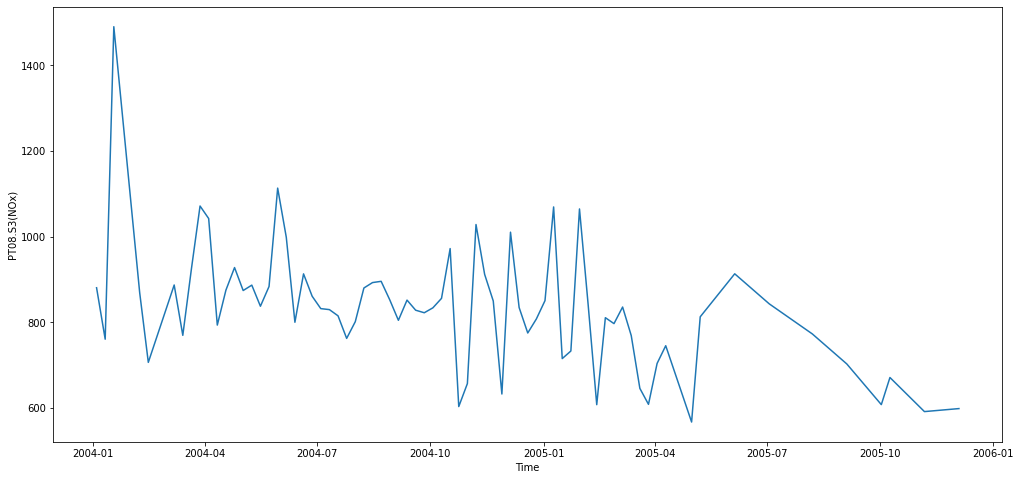

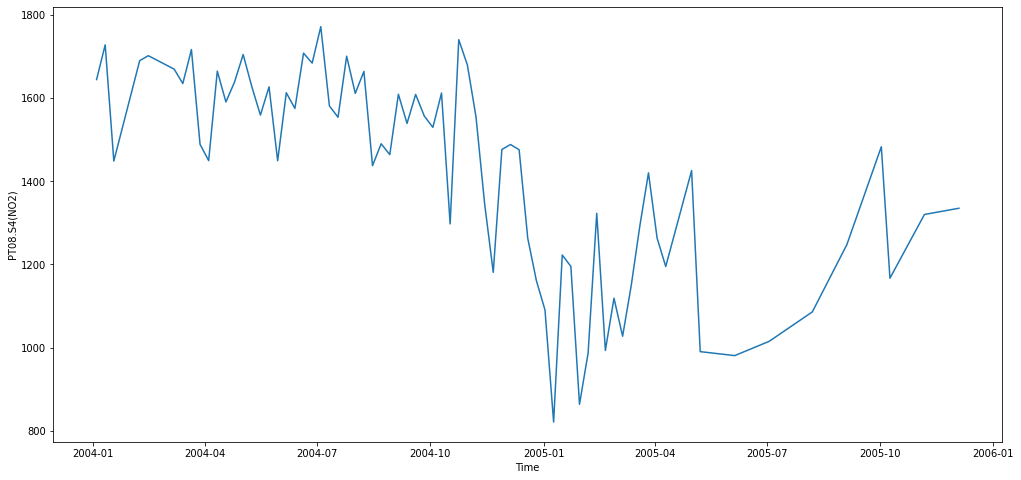

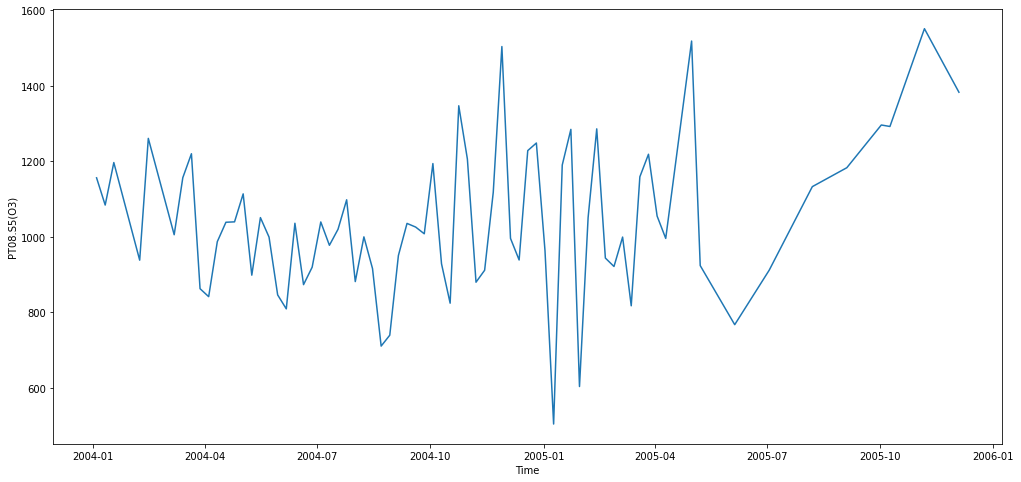

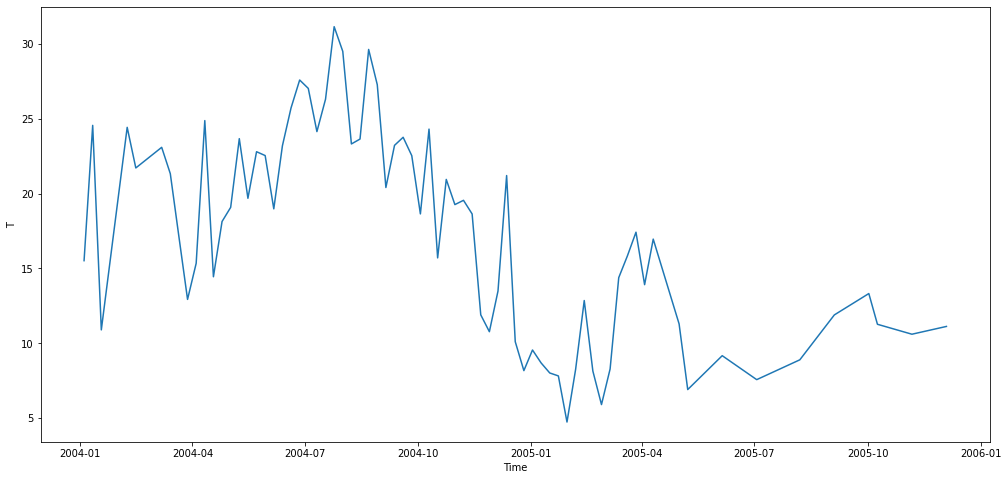

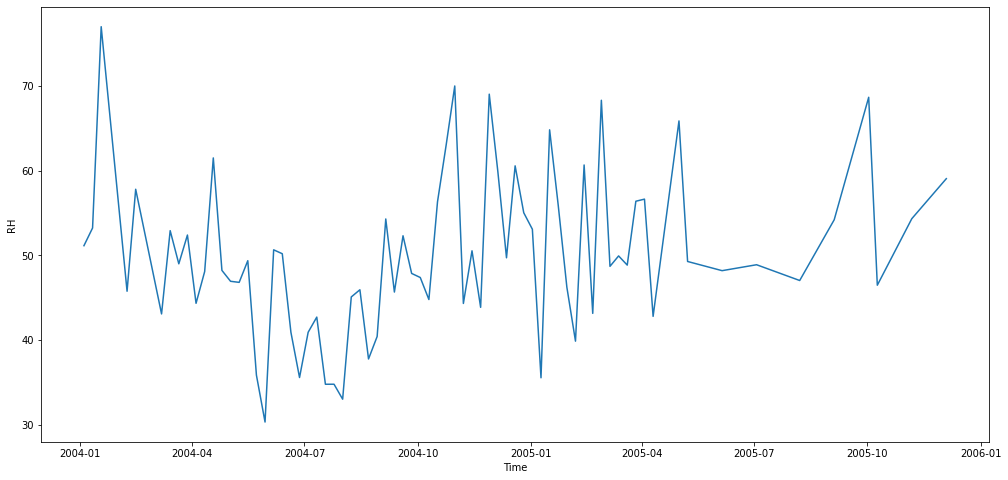

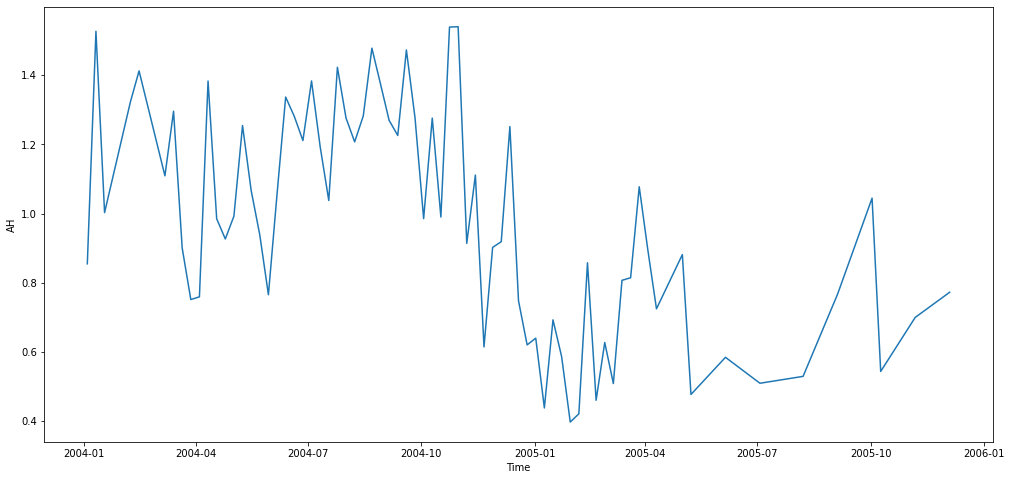

In [23]:
# plot the weekly concentration of each gas
def plot_data(col):
    plt.figure(figsize = (17,8))
    plt.plot(weekly_data[col])
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.grid(False)
    plt.show()
    
for col in weekly_data.columns:
    plot_data(col)

Oxides of nitrogen are very harmful, as they react to form smog and acid rain, as well as being responsible for the formation of fine particles and ground level ozone. These have adverse health effects, so the concentration of NOx is a key feature of air quality.

# Modelling

We will solely focus on modelling the NOx concentration. Therefore, we remove all other irrelevant columns.

Then, we import Prophet.

Prophet requires the date column to be named ds and the feature column to be named y, so we make the appropriate changes.

In [25]:
cols_to_drop = ["PT08.S1(CO)","C6H6(GT)","PT08.S2(NMHC)",'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

weekly_data = weekly_data.drop(cols_to_drop, axis = 1)

In [26]:
from prophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

In [27]:
# changing the column names according to Prophet's guidelines

df = weekly_data.reset_index()
df.columns = ['ds','y']
df.head()

,ds,y
0,2004-01-04,880.666667
1,2004-01-11,760.484990
2,2004-01-18,1490.333333
3,2004-02-08,869.108333
4,2004-02-15,706.395833


In [28]:
# split into a train/test set
prediction_size = 30
train_df = df[:-prediction_size]

In [29]:
train_df.shape

(43, 2)

In [30]:
# Initialize and train the model
m = Prophet()
m.fit(train_df)

01:47:54 - cmdstanpy - INFO - Chain [1] start processing
01:47:57 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
# make predictions
future = m.make_future_dataframe(periods = prediction_size)
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-01-04,947.676141,784.227579,1111.765165,947.676141,947.676141,0.0,0.0,0.0,0.0,0.0,0.0,947.676141
1,2004-01-11,944.839401,785.045504,1111.858450,944.839401,944.839401,0.0,0.0,0.0,0.0,0.0,0.0,944.839401
2,2004-01-18,942.002662,777.800535,1110.102885,942.002662,942.002662,0.0,0.0,0.0,0.0,0.0,0.0,942.002662
3,2004-02-08,933.492444,773.389314,1102.339667,933.492444,933.492444,0.0,0.0,0.0,0.0,0.0,0.0,933.492444
4,2004-02-15,930.655705,765.737037,1095.415068,930.655705,930.655705,0.0,0.0,0.0,0.0,0.0,0.0,930.655705


Here, yhat represents the prediction, while yhat_lower and yhat_upper represent the lower and upper bound of the prediction respectively.

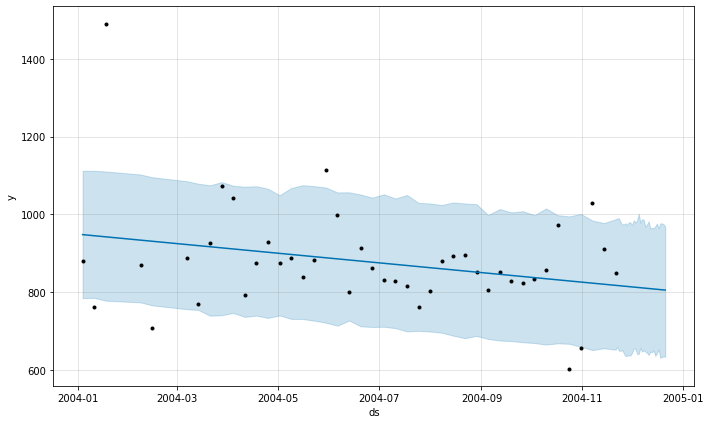

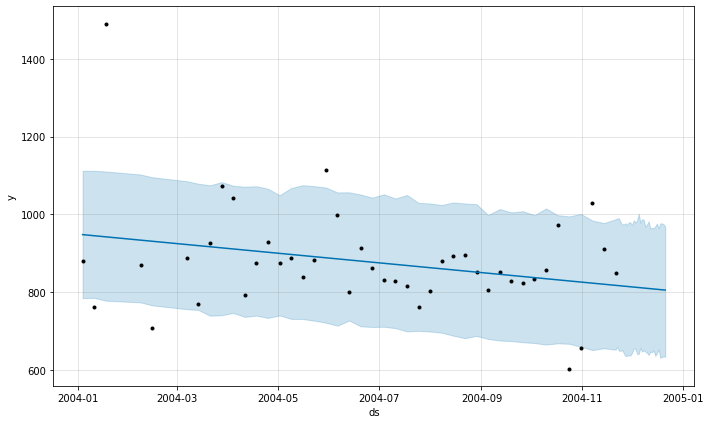

In [34]:
# plot forecast
m.plot(forecast)

As you can see, Prophet simply used a straight downward line to predict the concentration of NOx in the future.

Then, we check if the time series has any interesting features, such as seasonality:

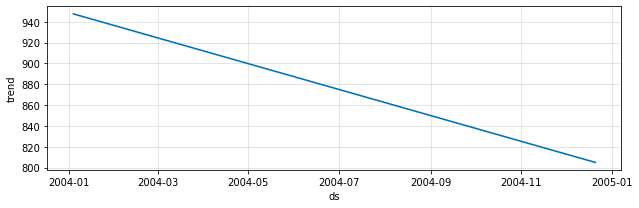

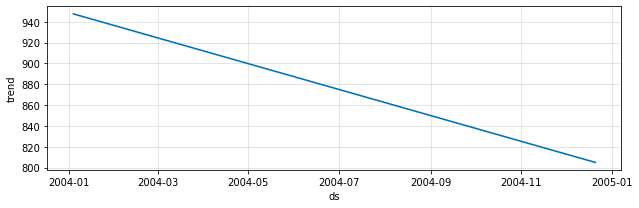

In [35]:
m.plot_components(forecast)

Here, Prophet only identified a downward trend with no seasonality.

In [36]:
# Evaluate the model
def make_comparision_dataframe(historical,forecast):
    return forecast.set_index("ds")[["yhat","yhat_lower","yhat_upper"]].join(historical.set_index('ds'))


In [37]:
cmp_df = make_comparision_dataframe(df,forecast)
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2004-01-04,947.676141,784.227579,1111.765165,880.666667
2004-01-11,944.839401,785.045504,1111.858450,760.484990
2004-01-18,942.002662,777.800535,1110.102885,1490.333333
2004-02-08,933.492444,773.389314,1102.339667,869.108333
2004-02-15,930.655705,765.737037,1095.415068,706.395833


In [43]:
def calculate_forecast_error(df,prediction_size):
    df = df.copy()
    
    df["e"] = df["y"] - df["yhat"]
    df["p"] = 100 * df["e"] /df["y"]
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_mean: np.mean(np.abs(predicted_part[error_mean]))
    
    return {"MAPE" : error_mean("p"), "MAE":error_mean("e")}


In [44]:
for err_name , err_value in calculate_forecast_error(cmp_df,prediction_size).items():
    print(err_name,err_value)

MAPE 13.874077771689764
MAE 109.32387955182077


Evaluating the model’s performance by calculating its mean absolute percentage error (MAPE) and mean absolute error (MAE), we see that the MAPE is 13.86% and the MAE is 109.32, which is not that bad! Remember that we did not fine tune the model at all.

Finally, we just plot the forecast with its upper and lower bounds:

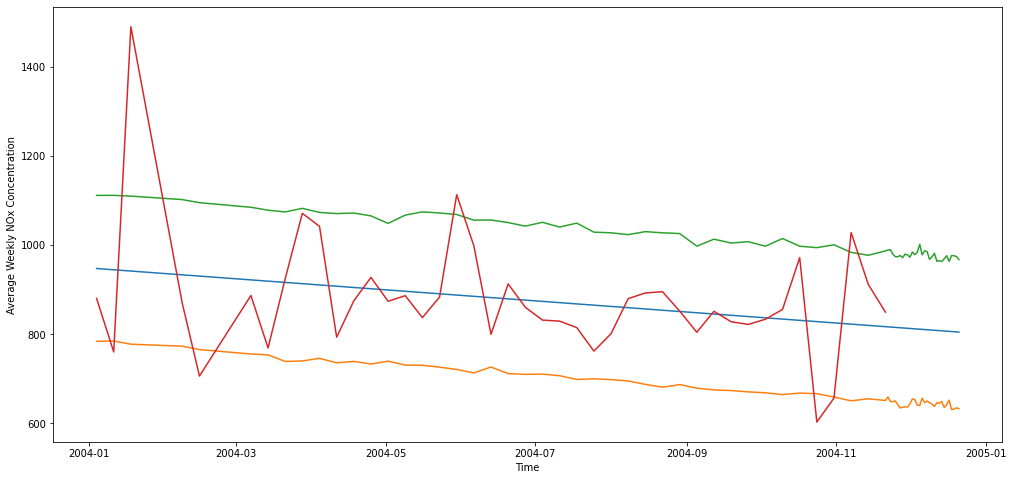

In [45]:
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Average Weekly NOx Concentration')
plt.grid(False)
plt.show()